In [1]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import wandb
import warnings

In [2]:
ENTITY_NAME = "sketchy-opts"
PROJECT_NAME_BASE = "gp_inference_"
METRIC_NAME_BASE = "metrics.callback."
METRIC_NAME_MAP = {"test_rmse": "Test RMSE", "test_posterior_samples_mean_nll": "Test Mean NLL", "train_rmse": "Train RMSE"}
X_AXIS_NAME_MAP = {"datapasses": "Datapasses",
                  "iterations": "Iterations", "time": "Time (s)"}
BOUND_FILL = 0.2
FONTSIZE = 20
LEGEND_SPECS = {
    "loc": "upper center",
    "bbox_to_anchor": (0.5, 0.0),
    "ncol": 3,
    "frameon": False,
}

dataset = "houseelec"
metric = "test_rmse"
x_axis_name = "time"

In [3]:
api = wandb.Api()

In [4]:
runs = api.runs(f"{ENTITY_NAME}/{PROJECT_NAME_BASE}{dataset}")

In [5]:
def render_in_latex():
    plt.rcParams.update({"text.usetex": True, "font.family": "serif"})

In [6]:
def set_fontsize(fontsize):
    plt.rcParams.update({"font.size": fontsize})

In [7]:
@dataclass(kw_only=True, frozen=True)
class MetricData:
    """Data class to hold metric data for a run."""
    metric_name: str
    metric_data: np.ndarray
    steps: np.ndarray
    datapasses: np.ndarray
    cum_times: np.ndarray
    finished: bool

    def get_final_time(self) -> float:
        """Return the last element in the cum_times array."""
        if len(self.cum_times) == 0:
            raise ValueError("cum_times array is empty.")
        return self.cum_times[-1]

    def get_plotting_name(self) -> str:
        """Return the name of the metric for plotting."""
        return self.metric_name
    
    def get_plotting_x_axis(self, xaxis) -> str:
        if xaxis not in X_AXIS_NAME_MAP:
            raise ValueError(f"Invalid x-axis name: {xaxis}. Must be one of {X_AXIS_NAME_MAP}.")
        if xaxis == "datapasses":
            return self.datapasses
        elif xaxis == "iterations":
            return self.steps
        elif xaxis == "time":
            return self.cum_times

class WandbRun:
    def __init__(self, run):
        self.run = run

    @property
    def opt_name(self) -> str:
        if self.run.config["solver_name"] == "sap":
            if self.run.config["solver_config"].get("precond_config", None):
                return r"\texttt{ADASAP}"
            else:
                return r"\texttt{ADASAP-I}"
        elif self.run.config["solver_name"] == "sdd":
            return f"SDD-{self.run.config['opt_step_size_unscaled']}"
        elif self.run.config["solver_name"] == "pcg":
            if self.run.config["solver_config"].get("precond_config", None):
                return "PCG"
        else:
            raise ValueError(f"Unknown solver name: {self.run.config['solver_name']}")
    
    @property
    def color(self) -> str:
        if self.opt_name == r"\texttt{ADASAP}":
            return "tab:blue"
        elif self.opt_name == r"\texttt{ADASAP-I}":
            return "tab:orange"
        elif self.opt_name == "SDD-1":
            return "tab:purple"
        elif self.opt_name == "SDD-10":
            return "tab:pink"
        elif self.opt_name == "SDD-100":
            return "tab:brown"
        elif self.opt_name == "PCG":
            return "tab:olive"
        else:
            raise ValueError(f"Unknown optimizer name: {self.opt_name}")
        
    def _get_num_blocks(self) -> int:
        if self.run.config["solver_name"] in ["sap", "sdd"]:
            return self.run.config["opt_num_blocks"]
        elif self.run.config["solver_name"] == "pcg":
            return 1
        
    def get_metric_data(self, metric: str) -> MetricData:
        full_metric_name = f"{METRIC_NAME_BASE}{metric}"
        run_hist = self.run.scan_history(
            keys=[full_metric_name, "_step", "iter_time"])

        # Extract raw data
        metric_data = np.array([x[full_metric_name] for x in run_hist])
        steps = np.array([x["_step"] for x in run_hist])
        times = np.array([x["iter_time"] for x in run_hist])

        # Identify unique step indices -- this is needed to remove duplicates
        _, unique_indices = np.unique(steps, return_index=True)
        unique_indices = np.sort(unique_indices)  # Sort to maintain original order

        # Filter to keep only unique step entries
        metric_data = metric_data[unique_indices]
        times = times[unique_indices]
        steps = steps[unique_indices]
        
        num_blocks = self._get_num_blocks()
        datapasses = steps / num_blocks

        # Calculate cumulative times
        cum_times = np.cumsum(times)

        return MetricData(
            metric_name=METRIC_NAME_MAP[metric],
            metric_data=metric_data,
            steps=steps,
            datapasses=datapasses,
            cum_times=cum_times,
            finished=True if self.run.state == "finished" else False,
        )

In [8]:
def _compute_metric_statistics(
    metrics_list: list[MetricData],
) -> tuple[MetricData, MetricData, MetricData]:
    """
    Compute mean, minimum, and maximum for a list of MetricData objects.
    
    Args:
        metrics_list: List of MetricData objects
        
    Returns:
        Tuple of (mean_data, min_data, max_data)
    """
    # Check if all metrics have the same metric name
    reference = metrics_list[0]
    all_same_name = all(m.metric_name == reference.metric_name
                        for m in metrics_list)
    if not all_same_name:
        raise ValueError(
            "All MetricData objects must have the same metric name")

    # Check if all metrics have the same steps
    reference = metrics_list[0]
    all_same_steps = all(np.array_equal(m.steps, reference.steps)
                         for m in metrics_list)

    if not all_same_steps:
        # raise ValueError("All MetricData objects must have the same steps")
        warnings.warn("Not all MetricData objects have the same steps. "
                      "This may lead to incorrect results. "
                      "This is likely because some runs were not finished. "
                      "We will return None for the mean, min, and max data.")
        # Return None for mean, min, and max data
        return None, None, None

    # Stack metric data along a new axis
    stacked_metrics = np.stack([m.metric_data for m in metrics_list], axis=0)

    # Stack cum_times data
    stacked_cum_times = np.stack([m.cum_times for m in metrics_list], axis=0)

    # Compute means
    mean_metrics = np.mean(stacked_metrics, axis=0)
    mean_cum_times = np.mean(stacked_cum_times, axis=0)

    # Find actual min and max values
    min_metrics = np.min(stacked_metrics, axis=0)
    max_metrics = np.max(stacked_metrics, axis=0)

    # Check if all runs are finished
    all_finished = all(m.finished for m in metrics_list)

    # Create MetricData objects for mean, min, and max
    mean_data = MetricData(
        metric_data=mean_metrics,
        steps=reference.steps,
        datapasses=reference.datapasses,
        cum_times=mean_cum_times,
        finished=all_finished,
        metric_name=reference.metric_name
    )

    min_data = MetricData(
        metric_data=min_metrics,
        steps=reference.steps,
        datapasses=reference.datapasses,
        cum_times=mean_cum_times,  # Using the same mean cum_times for all
        finished=all_finished,
        metric_name=reference.metric_name
    )

    max_data = MetricData(
        metric_data=max_metrics,
        steps=reference.steps,
        datapasses=reference.datapasses,
        cum_times=mean_cum_times,  # Using the same mean cum_times for all
        finished=all_finished,
        metric_name=reference.metric_name
    )

    return mean_data, min_data, max_data

In [9]:
metrics_dict = {}
colors_dict = {}
for run in runs:
    run_obj = WandbRun(run)
    opt_name = run_obj.opt_name
    if opt_name not in metrics_dict:
        metrics_dict[opt_name] = []
        colors_dict[opt_name] = run_obj.color

    metric_data = run_obj.get_metric_data(metric)
    metrics_dict[opt_name].append(metric_data)


/tmp/ipykernel_2853049/1764501049.py:28: UserWarning: Not all MetricData objects have the same steps. This may lead to incorrect results. This is likely because some runs were not finished. We will return None for the mean, min, and max data.
  warnings.warn("Not all MetricData objects have the same steps. "


Skipping SDD-100 due to incomplete data.


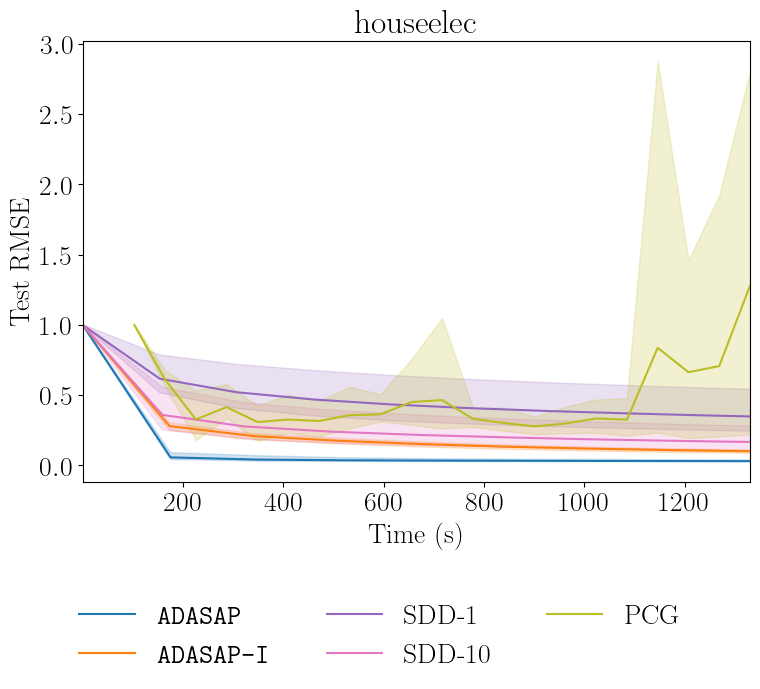

In [10]:
set_fontsize(FONTSIZE)
render_in_latex()

fig, ax = plt.subplots(figsize=(8, 6))

min_final_time = np.inf
xlims = (np.inf, -np.inf)
for i, (opt_name, metric_data_list) in enumerate(list(metrics_dict.items())):
    mean_data, lower_bound_data, upper_bound_data = _compute_metric_statistics(
        metric_data_list
    )

    if mean_data is None or lower_bound_data is None or upper_bound_data is None:
        print(f"Skipping {opt_name} due to incomplete data.")
        continue

    # Extract name for y-axis
    if i == 0:
        metric_name = mean_data.metric_name

    # Plot the mean and bounds if the runs were all finished
    if mean_data.finished:
        x_axis = mean_data.get_plotting_x_axis(x_axis_name)
        ax.plot(x_axis, mean_data.metric_data, label=opt_name, color=colors_dict[opt_name])
        ax.fill_between(
            x_axis,
            lower_bound_data.metric_data,
            upper_bound_data.metric_data,
            color=colors_dict[opt_name],
            alpha=BOUND_FILL,
        )

        # Update xlims
        xlims = (min(xlims[0], x_axis[0]), max(xlims[1], x_axis[-1]))

        # Track the final time for the x-axis limit
        min_final_time = min(min_final_time, mean_data.get_final_time())

# For time-based x-axis, set the second xlim to the minimum final time
if x_axis_name == "time":
    xlims = (xlims[0], min_final_time)

ax.set_xlim(xlims)
ax.set_xlabel(X_AXIS_NAME_MAP[x_axis_name])
ax.set_ylabel(metric_name)
ax.set_title(dataset)
fig.legend(**LEGEND_SPECS)
plt.tight_layout()
fig.show()

Skipping SDD-100 due to incomplete data.


/tmp/ipykernel_2853049/1764501049.py:28: UserWarning: Not all MetricData objects have the same steps. This may lead to incorrect results. This is likely because some runs were not finished. We will return None for the mean, min, and max data.
  warnings.warn("Not all MetricData objects have the same steps. "


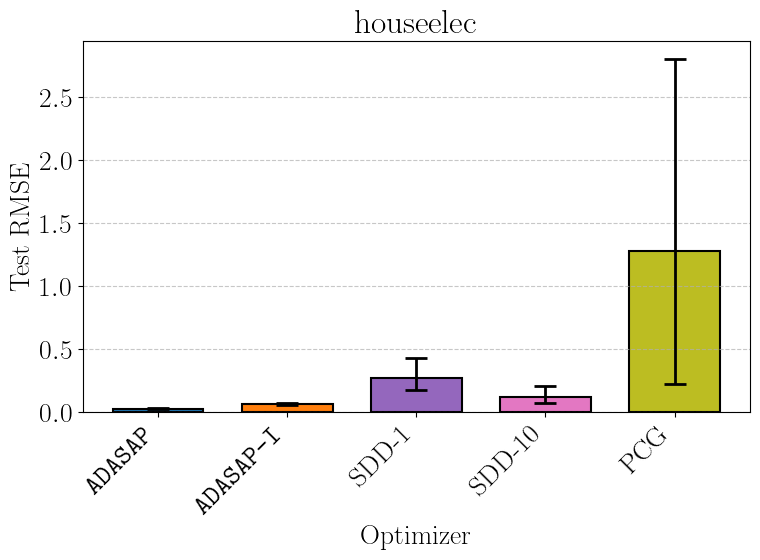

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

# Lists to store data for the bar chart
opt_names = []
final_values = []
lower_bounds = []
upper_bounds = []

for opt_name, metric_data_list in metrics_dict.items():
    mean_data, lower_bound_data, upper_bound_data = _compute_metric_statistics(
        metric_data_list
    )

    if mean_data is None or lower_bound_data is None or upper_bound_data is None:
        print(f"Skipping {opt_name} due to incomplete data.")
        continue

    # Extract name for y-axis
    metric_name = mean_data.metric_name

    # Store the final values (last element of each array)
    if mean_data.finished:
        opt_names.append(opt_name)
        final_values.append(mean_data.metric_data[-1])
        lower_bounds.append(lower_bound_data.metric_data[-1])
        upper_bounds.append(upper_bound_data.metric_data[-1])

# Calculate error bar heights
lower_errors = np.array(final_values) - np.array(lower_bounds)
upper_errors = np.array(upper_bounds) - np.array(final_values)
errors = np.vstack([lower_errors, upper_errors])

# Create bar positions
x_pos = np.arange(len(opt_names))

# Create the bar chart
bars = ax.bar(
    x_pos,
    final_values,
    width=0.7,
    align='center',
    yerr=errors,
    capsize=8,
    color=[colors_dict[name] for name in opt_names],
    edgecolor='black',
    linewidth=1.5,
    error_kw={'elinewidth': 2, 'capthick': 2}
)

# Add labels and title
ax.set_xlabel('Optimizer')
ax.set_ylabel(metric_name)
ax.set_title(dataset)
ax.set_xticks(x_pos)
ax.set_xticklabels(opt_names, rotation=45, ha='right')

# Add grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
fig.show()